In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

### 被抽单位转换成经纬度之后的数据处理

地区转经度纬度  http://lbs.tianditu.gov.cn/home.html

In [2]:
new_df = pd.read_csv("new.csv")
new_df.head(1)

,Unnamed: 0,标称地址,被抽单位,label,classify,Province,Spec,Source,Season,Company,latlon
0,0,六安市光明东路阳光水岸南出口2楼,六安市金安区老朱餐馆,0,52429.0,4,135937,2,4,1,"116.508104,31.77091"


In [3]:
new_df.drop(["Unnamed: 0", "被抽单位","标称地址"], axis=1, inplace=True)
new_df.isnull().sum()

label       0
classify    0
Province    0
Spec        0
Source      0
Season      0
Company     0
latlon      0
dtype: int64

In [4]:
def ff( item ):   
    item = item.latlon
    try:
        x, y = item.split(",")
        x = round(float(x), 2)
        y = round(float(y), 2)
    except:
        x,y = 0,0        
    return x,y  

p = new_df.apply(ff,axis=1).tolist()
p = list( zip(*p))
new_df["X"],new_df["Y"] = p[0],p[1]

new_df.drop("latlon", axis=1, inplace=True)

new_df = new_df.sample(new_df.shape[0]).reset_index(drop=True)
new_df.head()

,label,classify,Province,Spec,Source,Season,Company,X,Y
0,1,44757.0,3,1,2,2,23,114.02,32.99
1,0,77945.0,5,2131,2,4,4,115.53,28.06
2,0,19556.0,27,135937,1,4,41,0.00,0.00
3,0,77945.0,4,8980,1,4,2,116.26,32.34
4,1,70809.0,4,18134,1,4,3,119.41,30.90


In [5]:
#使其离散化
dummies = pd.get_dummies(new_df['Province'],prefix = 'Province')
dummies1 = pd.get_dummies(new_df['Source'],prefix = 'Source')
dummies2 = pd.get_dummies(new_df['Season'],prefix = 'Season')
dummies3 = pd.get_dummies(new_df['classify'],prefix = 'classify')
new_df = pd.concat([new_df,dummies,dummies1,dummies2,dummies3],axis=1)

### 模型训练

In [6]:
# 数据准备

X = new_df.drop('label', axis=1)
Y = new_df["label"]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [7]:
# 分类器

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

In [8]:
# 分类器 PK

for key, classifier in classifiers.items():
    classifier.fit(x_train, y_train)
    training_score = cross_val_score(classifier, x_train, y_train, cv=5)
    print(classifier.__class__.__name__, training_score.mean())

LogisticRegression 0.5722667929435191
KNeighborsClassifier 0.6919063471189941
RandomForestClassifier 0.7482090512243313


In [9]:
classifiers["RandomForestClassifier"].score(x_test, y_test)

0.7726688346063677

In [10]:
predict = classifiers["RandomForestClassifier"].predict(x_test)
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      6666
           1       0.79      0.73      0.76      6557

    accuracy                           0.77     13223
   macro avg       0.77      0.77      0.77     13223
weighted avg       0.77      0.77      0.77     13223



In [11]:
roc_auc_score(y_test, predict)

0.7723291964700512

In [12]:

clf = xgb.XGBClassifier(
    learning_rate=0.1, 
    n_estimators=200, 
    random_state=24, 
    verbose=True, 
    max_depth=5, 
    min_child_weight=1,
    subsample=0.8,
    objective="binary:logistic",
    seed=42
)

clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.7561824094381003

In [13]:

def modelfit(alg, x_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         print(cvresult)  # 看迭代效果变化
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(x_train, y_train, eval_metric='auc')
        
    #Predict training set:
    x_train_predictions = alg.predict(x_train)
    x_train_predprob = alg.predict_proba(x_train)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train, x_train_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, x_train_predprob))
                  
    xgb.plot_importance(alg)


Model Report
Accuracy : 0.7777
AUC Score (Train): 0.867194


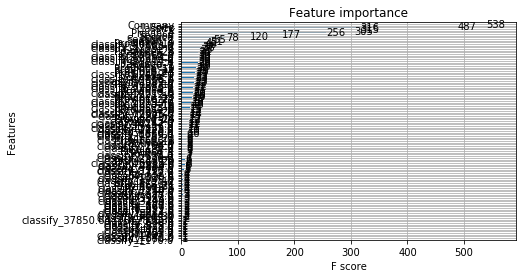

In [14]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=5,
 min_child_weight=1,
 subsample=0.8,
 colsample_bytree=0.7,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 seed=42,
 random_state=24,
 alpha=5
)
modelfit(xgb1, x_train, y_train)

In [15]:
xgb1.score(x_test, y_test)

0.7552748997958103

In [16]:
xgb1.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 200,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 24,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 42,
 'silent': None,
 'subsample': 0.8,
 'verbosity': 1,
 'alpha': 5}

In [17]:
#合并训练集与测试集，把模型评估的负样本率存入
df1 = pd.concat([x_train,x_test])
q = np.append(xgb1.predict_proba(x_train)[:, 0],xgb1.predict_proba(x_test)[:, 0])
df1['Negative rate of sample'] = q

In [18]:
df1.head()

,classify,Province,Spec,Source,Season,Company,X,Y,Province_1,Province_2,...,classify_37850.644167281534,classify_37883.0,classify_43592.0,classify_44757.0,classify_52429.0,classify_57666.0,classify_66294.0,classify_70809.0,classify_77945.0,Negative rate of sample
14988,25214.0,22,8,3,4,1,110.79,28.33,0,0,...,0,0,0,0,0,0,0,0,0,0.193005
7313,17253.0,8,12729,1,4,3,0.00,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0.722626
6816,70809.0,18,18134,1,4,40,0.00,0.00,0,0,...,0,0,0,0,0,0,0,1,0,0.074869
35742,43592.0,3,135937,5,2,3085,113.65,34.80,0,0,...,0,0,1,0,0,0,0,0,0,0.997020
26858,66294.0,22,662,1,2,2,111.66,27.70,0,0,...,0,0,0,0,0,0,1,0,0,0.810875


### 根据模型的负样本率进行推荐

In [19]:
#该字典中为表中的各个类别的值所代表的含义
with open ('importent_dict(1).pkl','rb')as f:
    importent_dict = pickle.load(f)

In [20]:
importent_dict

[{'饮料': 77945,
  '粮食加工品': 70809,
  '糕点': 66294,
  '酒类': 57666,
  '肉制品': 52429,
  '调味品': 44757,
  '食用农产品': 43592,
  '食用油、油脂及其制品': 37883,
  '蔬菜制品': 26194,
  '茶叶及相关制品': 25214,
  '餐饮食品': 24522,
  '乳制品': 21079,
  '水果制品': 19556,
  '速冻食品': 17513,
  '炒货食品及坚果制品': 17253,
  '水产制品': 16932,
  '豆制品': 13853,
  '糖果制品': 13575,
  '粮食及粮食制品': 12831,
  '方便食品': 12035,
  '罐头': 9866,
  '蜂产品': 9176,
  '淀粉及淀粉制品': 8884,
  '肉及肉制品': 7105,
  '焙烤食品': 6731,
  '饼干': 6659,
  '薯类和膨化食品': 6625,
  '蛋制品': 6247,
  '食品添加剂': 5272,
  '茶叶及其相关制品': 4870,
  '食糖': 4839,
  '冷冻饮品': 4370,
  '特殊膳食食品': 3913,
  '薯类及膨化食品': 3757,
  '蔬菜及其制品': 3200,
  '熟肉制品': 2688,
  '豆类及其制品': 2316,
  '水果及其制品': 2270,
  '畜禽肉及副产品': 2266,
  '食用植物油': 2203,
  '蔬菜': 1842,
  '婴幼儿配方食品': 1727,
  '糖果': 1726,
  '酱腌菜': 1723,
  '大米': 1696,
  '水产品': 1614,
  '糖果及可可制品': 1526,
  '乳基较大婴儿和幼儿配方食品、豆基较大婴儿和幼儿配方食品': 1295,
  '粽子': 1244,
  '发酵面制品': 1170,
  '水产品及水产制品': 1165,
  '乳基婴儿配方食品、豆基婴儿配方食品': 1096,
  '食用油': 1087,
  '保健食品': 1030,
  '畜肉': 989,
  '酱卤肉制品': 959,
  '其他粮食加工品': 880,
  '其他

In [21]:
classify_list = importent_dict[0]
Province_list = importent_dict[1]
Spec_list = importent_dict[2]
Source_list = importent_dict[3]

In [22]:
#把字典的键和值进行互换
def re_change(xx_list,xx):
    qwe = {}
    for key, value in zip(xx_list.values(), xx_list.keys()):
        qwe[key] = value
    df1[xx].map(qwe)
    return qwe

In [23]:
classify_cn = re_change(classify_list,'classify')
Province_cn = re_change(Province_list,'Province')
Spec_cn = re_change(Spec_list,'Spec')
Source_cn = re_change(Source_list,'Source')

In [24]:
#用中文替换对应的数字
def re_change_2(xx,qq):
    df1[xx]=df1[xx].map(qq)

In [25]:
re_change_2('classify',classify_cn)
re_change_2('Province',Province_cn)
re_change_2('Spec',Spec_cn)
re_change_2('Source',Source_cn)

In [26]:
df1.head()

,classify,Province,Spec,Source,Season,Company,X,Y,Province_1,Province_2,...,classify_37850.644167281534,classify_37883.0,classify_43592.0,classify_44757.0,classify_52429.0,classify_57666.0,classify_66294.0,classify_70809.0,classify_77945.0,Negative rate of sample
14988,茶叶及相关制品,上海,350g/筒,,4,1,110.79,28.33,0,0,...,0,0,0,0,0,0,0,0,0,0.193005
7313,炒货食品及坚果制品,浙江,250g/袋,国抽,4,3,0.00,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0.722626
6816,粮食加工品,天津,5kg/袋,国抽,4,40,0.00,0.00,0,0,...,0,0,0,0,0,0,0,1,0,0.074869
35742,食用农产品,湖北,散装,省抽专项,2,3085,113.65,34.80,0,0,...,0,0,1,0,0,0,0,0,0,0.997020
26858,糕点,上海,非定量包装,国抽,2,2,111.66,27.70,0,0,...,0,0,0,0,0,0,1,0,0,0.810875


In [27]:

#attribute = Province	Spec	Source	classify
#category = 江西;250ml/盒;国抽;饮料
def Recommend(attribute_1,category_1,attribute_2,category_2,qq):
    df1 = qq.loc[qq[attribute_1]==category_1]#单独取出去要的列
    df2 = df1.loc[qq[attribute_2]==category_2]
    
    inverted_order = df2.sort_values('Negative rate of sample',ascending=True)#对取出的列的负样本率进行正排序与负排序
    positive_sequence =df2.sort_values('Negative rate of sample',ascending=False)
    
    inverted_order_list1= inverted_order[attribute_2].to_list()
    positive_sequence_list1= positive_sequence[attribute_2].to_list()
    
    inverted_order_list2 = inverted_order['Negative rate of sample'].to_list()
    positive_sequence_list2 = positive_sequence['Negative rate of sample'].to_list()
    
    print('对于{}和{}，不推荐{}，{}和{}，推荐指数分别是{}，{}和{}。推荐{}，{}和{}，比例分别是{}，{}和{}。'.format(attribute_1,attribute_2,
                                                   inverted_order_list1[0],inverted_order_list1[1],inverted_order_list1[2],
                                                    round(inverted_order_list2[0],2),round(inverted_order_list2[1],2),round(inverted_order_list2[2],2),
                                                   positive_sequence_list1[0],positive_sequence_list1[1],positive_sequence_list1[2],
                                                  round(positive_sequence_list2[0],2) ,round(positive_sequence_list2[1],2),round(positive_sequence_list2[2]),2))
                                                   #round(a,x)x为保留小数的位数

In [28]:
Recommend('Province','江西','classify','饮料',df1)

对于Province和classify，不推荐饮料，饮料和饮料，比例分别是0.07，0.07和0.08。推荐饮料，饮料和饮料，比例分别是0.87，0.87和1。
